In [2]:
import os

import numpy as np
import numpy.linalg as la
from numpy import fft

import matplotlib as mpl
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import AsinhStretch
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.visualization import astropy_mpl_style
from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData

from photutils.detection import DAOStarFinder
from photutils.psf import EPSFBuilder
from photutils.psf import extract_stars

stretch = AsinhStretch()

plt.style.use(astropy_mpl_style)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'none'

%matplotlib inline
%config InlineBackend.figure_format='retina'

Prepare data

In [3]:
IMG_DIR = '/quasar/data/GO1764/NIRCam/redux_v01/'

img_paths = []

# Load F250M data
for filename in os.listdir(IMG_DIR): 
    if 'jw01764001001_02101' in filename and 'nrcblong' in filename:
        img_paths.append(os.path.join(IMG_DIR, filename))
img_paths.sort()

img_paths

['/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00001_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00002_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00003_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00004_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00005_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00006_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00007_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00008_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00009_nrcblong_cal_bsub_aligned.fits']

In [4]:
agn_coord = SkyCoord("J100758.26+211529.2", unit=(u.hourangle, u.deg), frame='icrs')

agn_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (151.99275, 21.25811111)>

Image Cutout

In [5]:
def create_cutout_fits(fits_path, cutout_path, coord, radius):
    '''
    Parameters: 
        fits_path:      string
        output_path:    string
        coord:          SkyCoord
        radius:         float (in arcsec)
    '''
    with fits.open(fits_path) as hdul:
        # read file
        header = hdul['SCI'].header
        # wcs.sip = None

        wcs = WCS(header)
        data = hdul['SCI'].data
        pixel_scale = wcs.proj_plane_pixel_scales()[0].value # degrees per pixel
        radius_pix = int(radius/3600/pixel_scale)
        size = (radius_pix*2, radius_pix*2)

        # Create the cutout
        cutout = Cutout2D(data, coord, size, wcs=wcs)
        hdul['SCI'].header.update(cutout.wcs.to_header())

        # Create new FITS HDUs
        new_hdul = fits.HDUList([fits.PrimaryHDU(header=hdul[0].header)])
        for hdu_name in ['SCI', 'ERR', 'DQ', 'AREA', 'VAR_POISSON', 'VAR_RNOISE', 'VAR_FLAT']:
            if hdu_name in hdul:
                hdu_data = Cutout2D(hdul[hdu_name].data, coord, size, wcs=wcs)
                new_hdu = fits.ImageHDU(data=hdu_data.data, header=hdul[hdu_name].header, name=hdu_name)
                new_hdu.header.update(hdu_data.wcs.to_header())
                new_hdul.append(new_hdu)

        # Write the new cutout to a FITS file
        new_hdul.writeto(cutout_path, overwrite=False)
        print(f"Cutout saved to {cutout_path}")

In [6]:
radius = 2 # arcsec
cutout_dir = '/quasar/yichenliu/cutout'
cutout_paths = []
for fits_path in img_paths: 
    print(f' processing {fits_path}')
    directory = os.path.dirname(fits_path)
    filename = os.path.basename(fits_path)
    cutout_path = os.path.join(cutout_dir, filename[:-5]+'_cutout.fits')
    try: 
        create_cutout_fits(fits_path, cutout_path, agn_coord, 2)
    except OSError as E: 
        print(f'  ERROR: {E}')
    cutout_paths.append(cutout_path)
    # break

 processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00001_nrcblong_cal_bsub_aligned.fits
  ERROR: File /quasar/yichenliu/cutout/jw01764001001_02101_00001_nrcblong_cal_bsub_aligned_cutout.fits already exists. If you mean to replace it then use the argument "overwrite=True".
 processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00002_nrcblong_cal_bsub_aligned.fits


Set DATE-AVG to '2023-05-10T01:57:32.636' from MJD-AVG.
Set DATE-END to '2023-05-10T02:01:07.371' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.931130 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540023708.650 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:05:57.275' from MJD-AVG.
Set DATE-END to '2023-05-10T02:09:32.010' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.934391 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540070416.745 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


  ERROR: File /quasar/yichenliu/cutout/jw01764001001_02101_00002_nrcblong_cal_bsub_aligned_cutout.fits already exists. If you mean to replace it then use the argument "overwrite=True".
 processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00003_nrcblong_cal_bsub_aligned.fits
  ERROR: File /quasar/yichenliu/cutout/jw01764001001_02101_00003_nrcblong_cal_bsub_aligned_cutout.fits already exists. If you mean to replace it then use the argument "overwrite=True".
 processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00004_nrcblong_cal_bsub_aligned.fits


Set DATE-AVG to '2023-05-10T02:14:32.667' from MJD-AVG.
Set DATE-END to '2023-05-10T02:18:07.402' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.938060 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540122949.033 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:22:57.306' from MJD-AVG.
Set DATE-END to '2023-05-10T02:26:32.041' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.941320 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540169631.670 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


  ERROR: File /quasar/yichenliu/cutout/jw01764001001_02101_00004_nrcblong_cal_bsub_aligned_cutout.fits already exists. If you mean to replace it then use the argument "overwrite=True".
 processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00005_nrcblong_cal_bsub_aligned.fits
  ERROR: File /quasar/yichenliu/cutout/jw01764001001_02101_00005_nrcblong_cal_bsub_aligned_cutout.fits already exists. If you mean to replace it then use the argument "overwrite=True".
 processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00006_nrcblong_cal_bsub_aligned.fits


Set DATE-AVG to '2023-05-10T02:31:32.634' from MJD-AVG.
Set DATE-END to '2023-05-10T02:35:07.369' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.944987 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540222135.322 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:39:57.273' from MJD-AVG.
Set DATE-END to '2023-05-10T02:43:32.008' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.948247 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540268792.514 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


  ERROR: File /quasar/yichenliu/cutout/jw01764001001_02101_00006_nrcblong_cal_bsub_aligned_cutout.fits already exists. If you mean to replace it then use the argument "overwrite=True".
 processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00007_nrcblong_cal_bsub_aligned.fits
  ERROR: File /quasar/yichenliu/cutout/jw01764001001_02101_00007_nrcblong_cal_bsub_aligned_cutout.fits already exists. If you mean to replace it then use the argument "overwrite=True".
 processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00008_nrcblong_cal_bsub_aligned.fits


Set DATE-AVG to '2023-05-10T02:48:32.665' from MJD-AVG.
Set DATE-END to '2023-05-10T02:52:07.400' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.951913 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540321267.547 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:56:57.304' from MJD-AVG.
Set DATE-END to '2023-05-10T03:00:32.039' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.955171 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540367899.307 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T03:05:32.632' from MJD-AVG.
Set DATE-END to '2023-05-10T03:09:07.367' from MJD-END'. [astropy.wcs.wcs]


  ERROR: File /quasar/yichenliu/cutout/jw01764001001_02101_00008_nrcblong_cal_bsub_aligned_cutout.fits already exists. If you mean to replace it then use the argument "overwrite=True".
 processing /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00009_nrcblong_cal_bsub_aligned.fits
  ERROR: File /quasar/yichenliu/cutout/jw01764001001_02101_00009_nrcblong_cal_bsub_aligned_cutout.fits already exists. If you mean to replace it then use the argument "overwrite=True".


Set OBSGEO-B to   -21.958836 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540420345.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


display cutouts

In [7]:
def get_pixel_center_coordinate(fits_path):
    with fits.open(fits_path) as hdul:
        wcs = WCS(hdul['SCI'].header)
        ny, nx = hdul['SCI'].data.shape
        center_x = (nx - 1) / 2
        center_y = (ny - 1) / 2
        sky_coord = wcs.pixel_to_world(center_x, center_y)
        return center_x, center_y, sky_coord

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
(array(30.24340447),

Set OBSGEO-B to   -21.931130 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540023708.650 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.934391 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540070416.745 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.938060 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540122949.033 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.941320 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540169631.670 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.944987 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540222135.322 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.948247 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540268792.514 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.951913 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540321267.547 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.955171 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540367899.307 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
             

Set OBSGEO-B to   -21.958836 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540420345.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


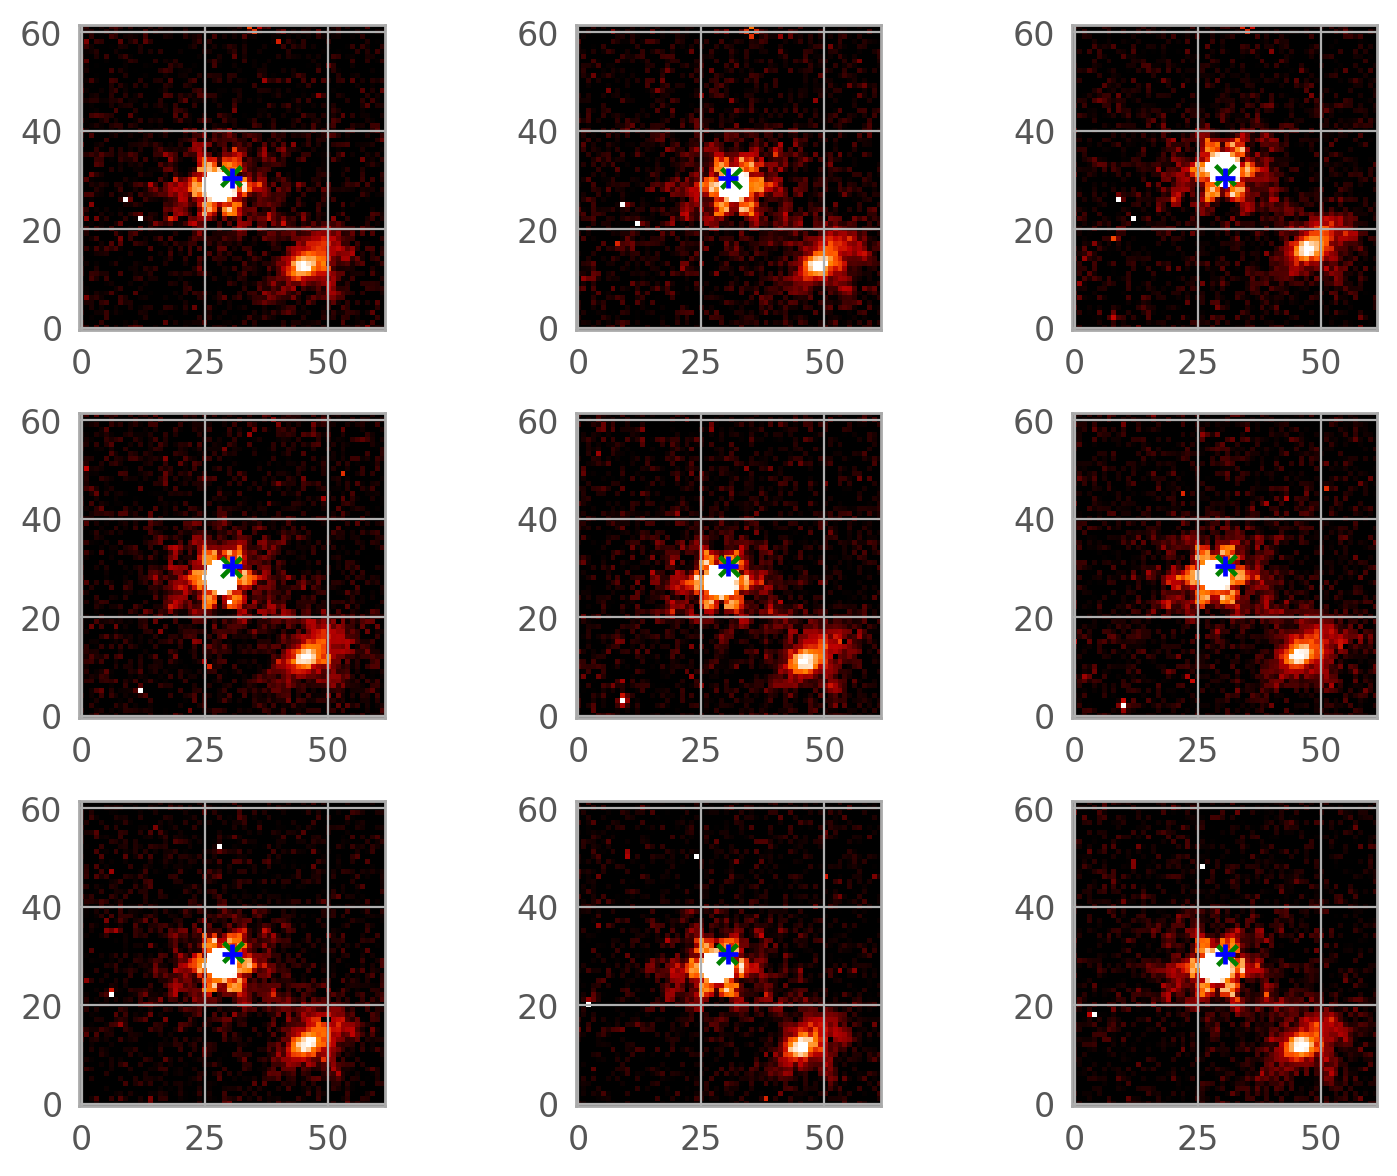

In [8]:
fig, axs = plt.subplots(3, 3)
axs = axs.flat

agn_pixels = []

for i in range(9): 
    with fits.open(cutout_paths[i]) as hdul: 
        data = hdul[1].data
        wcs = WCS(hdul[1].header)
        agn_pixel = wcs.world_to_pixel(agn_coord)
        print(agn_pixel)
        axs[i].imshow(stretch(data))
        axs[i].scatter(agn_pixel[0], agn_pixel[1], marker='x', c='g', s=50)
        x, y, _ = get_pixel_center_coordinate(cutout_paths[i])
        axs[i].scatter(x, y, marker='+', c='b', s=50)
        agn_pixels.append(agn_pixel)
        # axs[i].grid(False)

agn_pixels = np.array(agn_pixels)

plt.tight_layout()

Manually find its center

In [9]:
centroids = []

for i in range(9): 
    with fits.open(cutout_paths[i]) as hdul: 
        data = hdul[1].data
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.0*std)
    sources = daofind(data - median)
    source = sources[sources['flux']==np.max(sources['flux'])][0]
    x = source['xcentroid']
    y = source['ycentroid']
    centroids.append([x, y])
centroids = np.array(centroids)

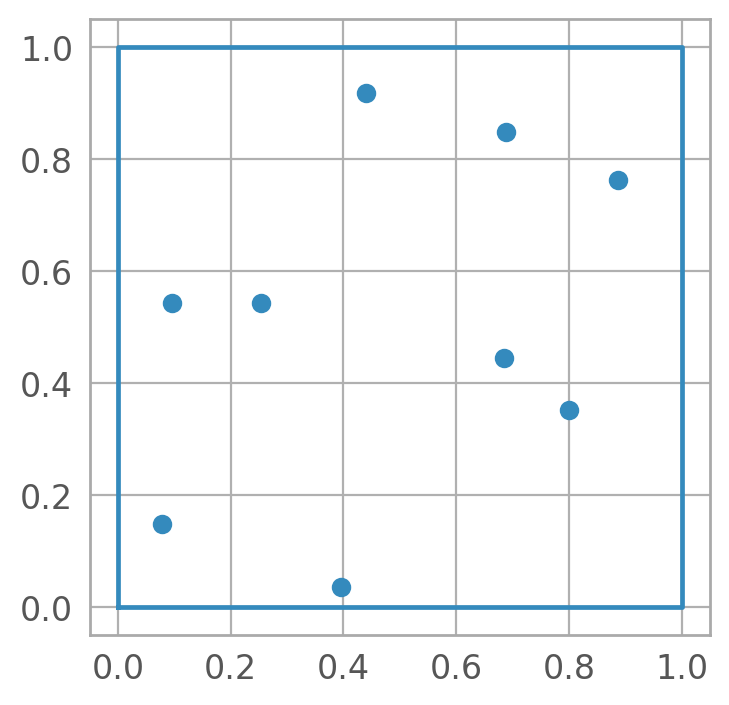

In [11]:
centroid_floor = centroids-np.floor(centroids)

plt.figure(figsize=[4, 4])
plt.scatter(*centroid_floor.T)
plt.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0])

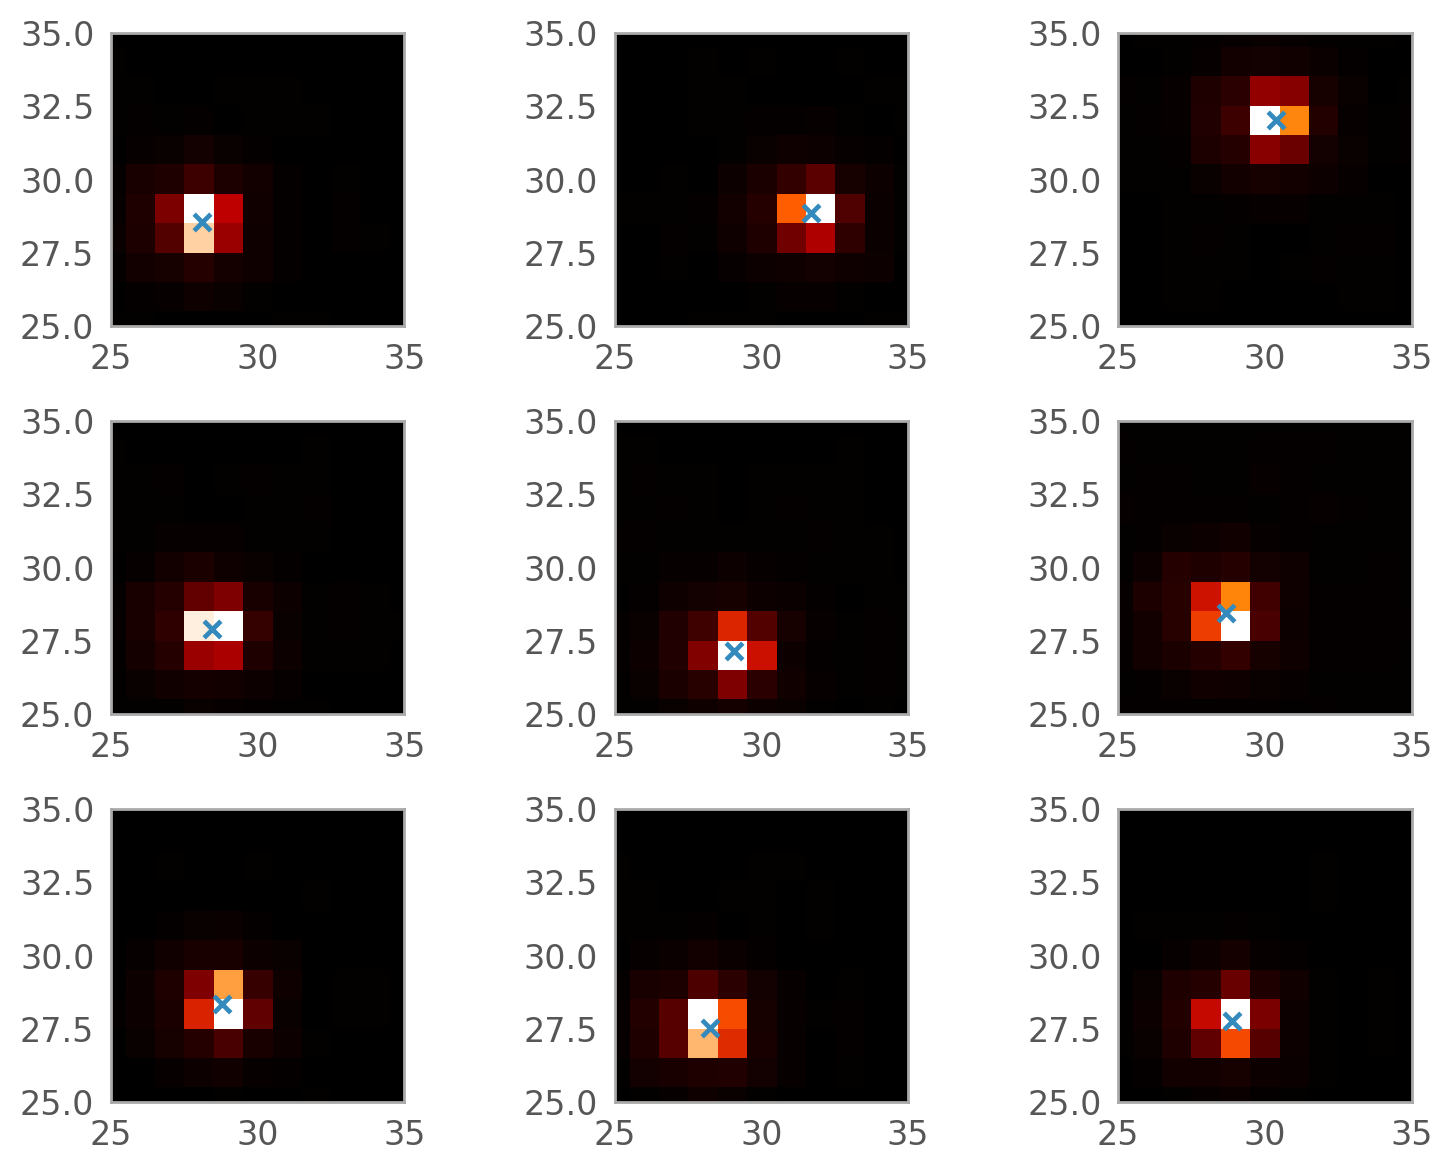

In [12]:
fig, axs = plt.subplots(3, 3)
axs = axs.flat

for i in range(9): 
    with fits.open(cutout_paths[i]) as hdul: 
        data = hdul[1].data
        axs[i].imshow(data)
        axs[i].scatter(*centroids[i], marker='x')
        axs[i].set_xlim(25, 35)
        axs[i].set_ylim(25, 35)
        axs[i].grid(False)

plt.tight_layout()

read cutouts

In [50]:
orig_atlas = []
for cutout_path in cutout_paths: 
    with fits.open(cutout_path) as hdul: 
        data = hdul[1].data
        orig_atlas.append(data)

Shift each image so that their center differences are within 1 pixel

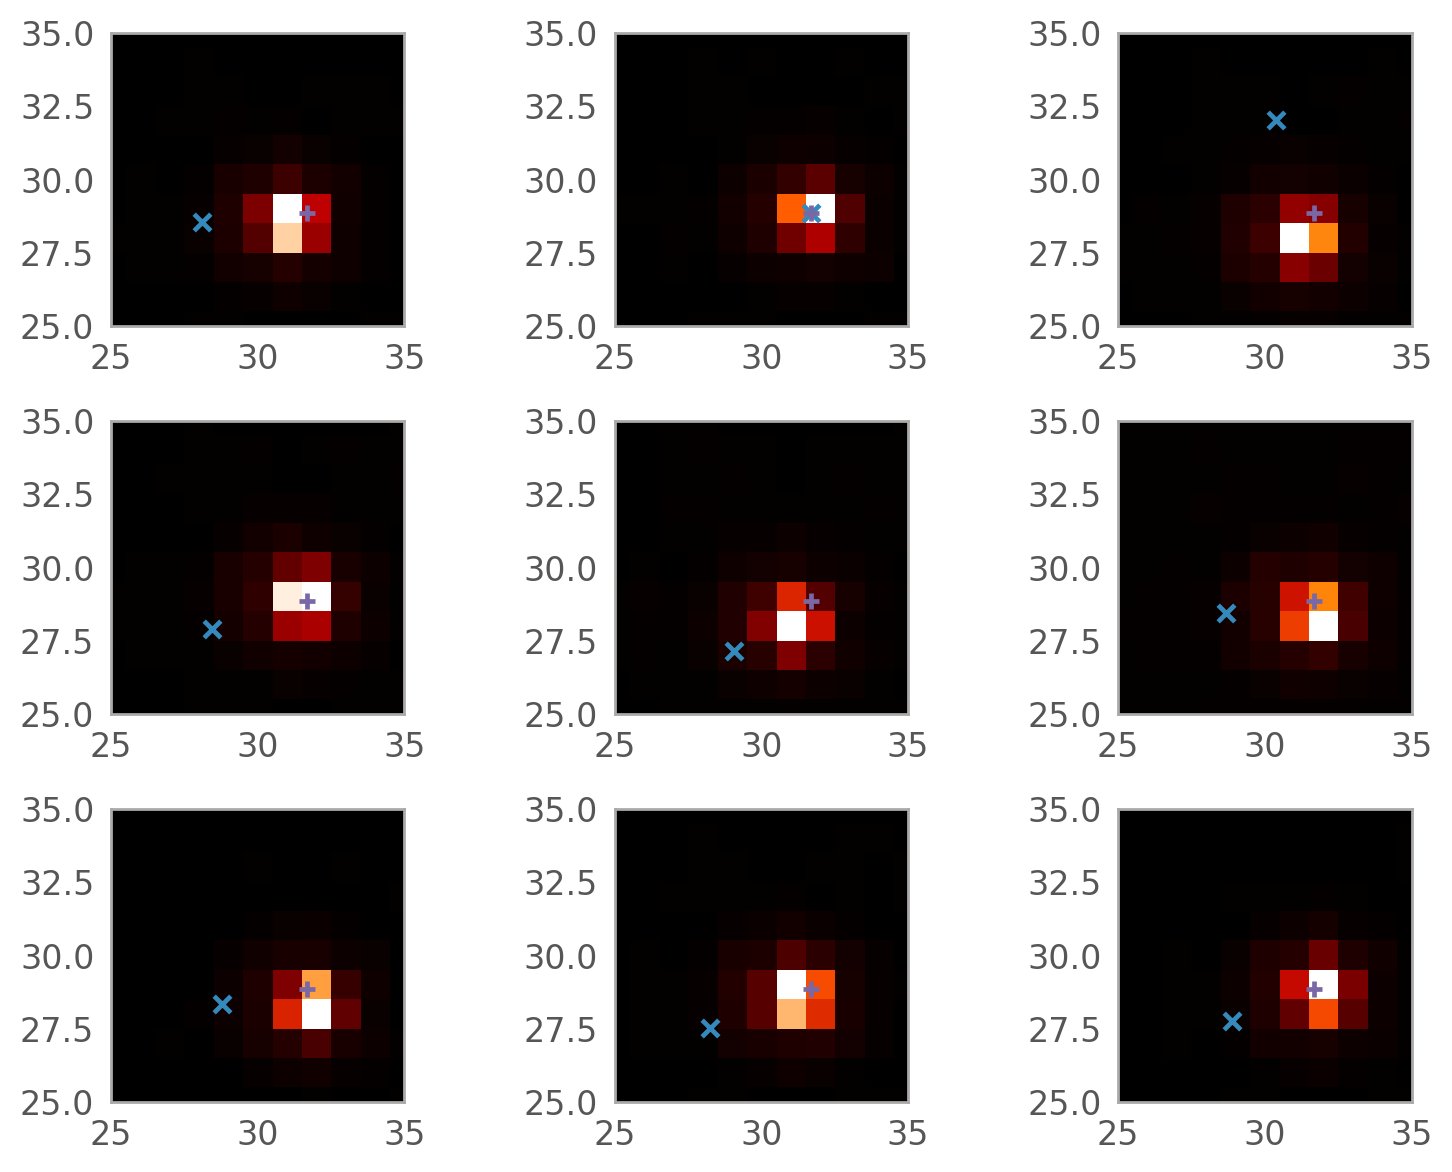

In [88]:
centroids_floor = np.floor(centroids).astype(np.int64)

shifted_atlas = []
for i in range(9): 
    data = orig_atlas[i]
    dx = centroids_floor[i, 0] - centroids_floor[1, 0]
    dy = centroids_floor[i, 1] - centroids_floor[1, 1]
    shifted_data = np.roll(np.roll(data, -dy, axis=0), -dx, axis=1)
    shifted_atlas.append(shifted_data)

fig, axs = plt.subplots(3, 3)
axs = axs.flat

for i in range(9): 
    data = shifted_atlas[i]
    axs[i].imshow(data)
    axs[i].scatter(*centroids[i], marker='x')
    axs[i].scatter(*centroids[1], marker='+')
    axs[i].set_xlim(25, 35)
    axs[i].set_ylim(25, 35)
    # axs[i].set_xlim(0, 10)
    # axs[i].set_ylim(0, 10)
    axs[i].grid(False)

plt.tight_layout()

enlarge images

In [109]:

factor = 3
old_shape = shifted_atlas[0].shape
new_shape = (old_shape[0]*factor, old_shape[1]*factor)
large_atlas = []
for data in shifted_atlas: 
    large_data = np.zeros(new_shape, dtype=data.dtype)
    large_data[::factor, ::factor] = data
    # large_data = np.repeat(np.repeat(data, 3, axis=0), 3, axis=1)
    large_atlas.append(large_data)

Construct the 3-D ($9\times ny \times nx$) detection matrix $\hat{\textbf D}$

In [110]:
D_hat = []
for large_data in large_atlas:
    large_data_hat = fft.fft2(large_data)
    D_hat.append(large_data_hat)
D_hat = np.array(D_hat, dtype=large_data_hat.dtype)

Construct the 2-D ($9\times9$) transformation matrix $\hat{\mathbf\Phi}$

$$
\hat{\mathbf\Phi}=\frac{1}{9}\left(\begin{array}{cccc}
1 & e^{-\pi i x_1} & e^{-x y_1} & \dots & e^{-\pi i\left(2x_1+2y_1\right)} \\
1 & e^{-\pi i x_2} & e^{-x y_2} & \dots & e^{-x i\left(2x_2+2y_2\right)} \\
\vdots & \vdots & \vdots & \dots & \vdots \\
1 & e^{-\pi i x_n} & e^{-x y_n} & \dots & e^{-\pi i\left(2x_n+2y_n\right)}
\end{array}\right)
$$

In [111]:
x = centroids.T[0] - centroids[0, 0]
y = centroids.T[1] - centroids[0, 1]

Phi_hat = np.zeros((9, 9), dtype=D_hat.dtype)
for i in range(9): 
    for j in range(9): 
        dx = centroids[i, 0]
        dy = centroids[i, 1]
        mx = j//3
        my = j%3
        Phi_hat[i, j] = np.exp(-np.pi*1j*(mx*dx+my*dy))
Phi_hat = Phi_hat/9

Solve for $\hat{\mathbf F}$ in the linear equation $\hat{\mathbf\Phi} \hat{\mathbf F} = \hat{\mathbf D}$:

In [112]:
_, nx, ny = D_hat.shape

D_hat_flat = D_hat.reshape(9, nx*ny)

F_hat_flat = la.lstsq(Phi_hat, D_hat_flat)[0]

F_hat = F_hat_flat.reshape(9, nx, ny)

/tmp/ipykernel_828839/2266520460.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F_hat_flat = la.lstsq(Phi_hat, D_hat_flat)[0]


Get the real representation $F$

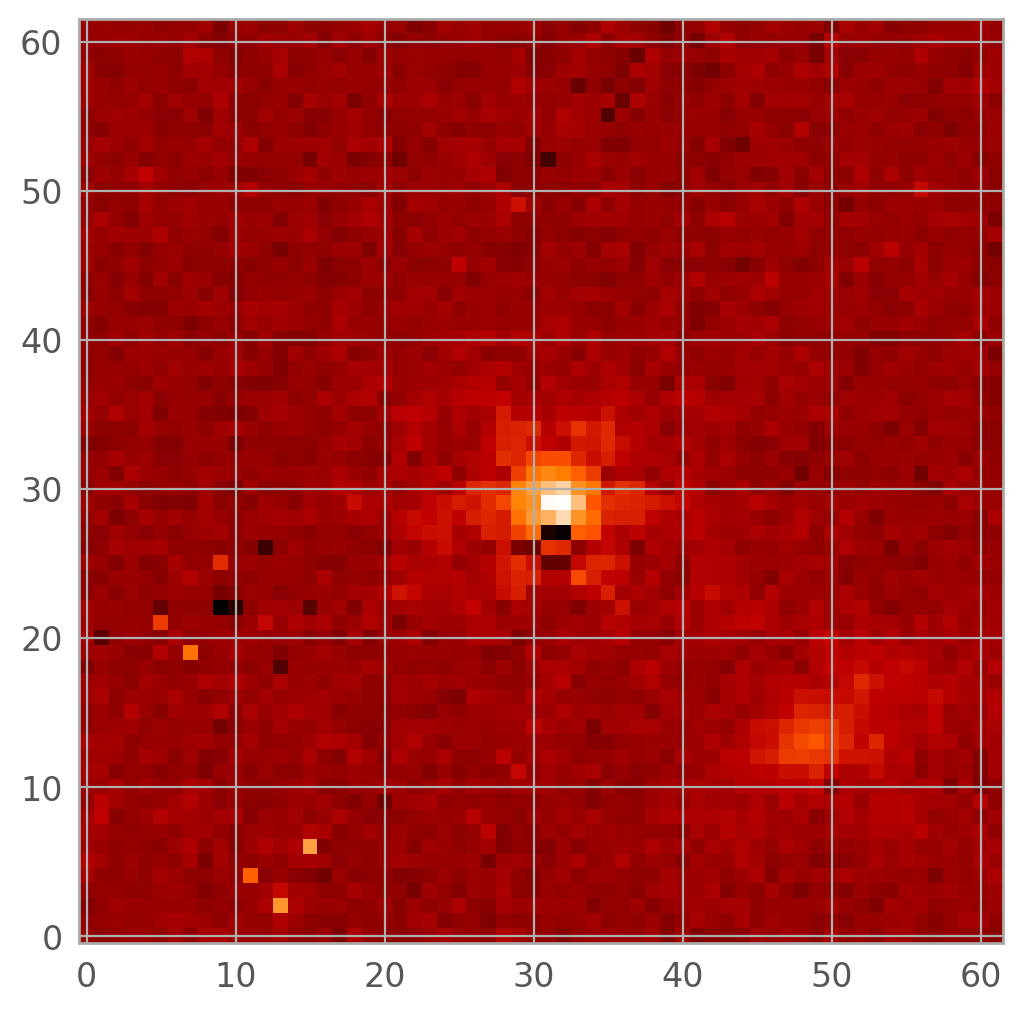

In [116]:
F = fft.ifft2(F_hat[0]).real

# plt.imshow(stretch(F[::3, ::3]))
# plt.imshow(np.arcsinh(F))

plt.imshow(np.arcsinh(F[::3, ::3]))

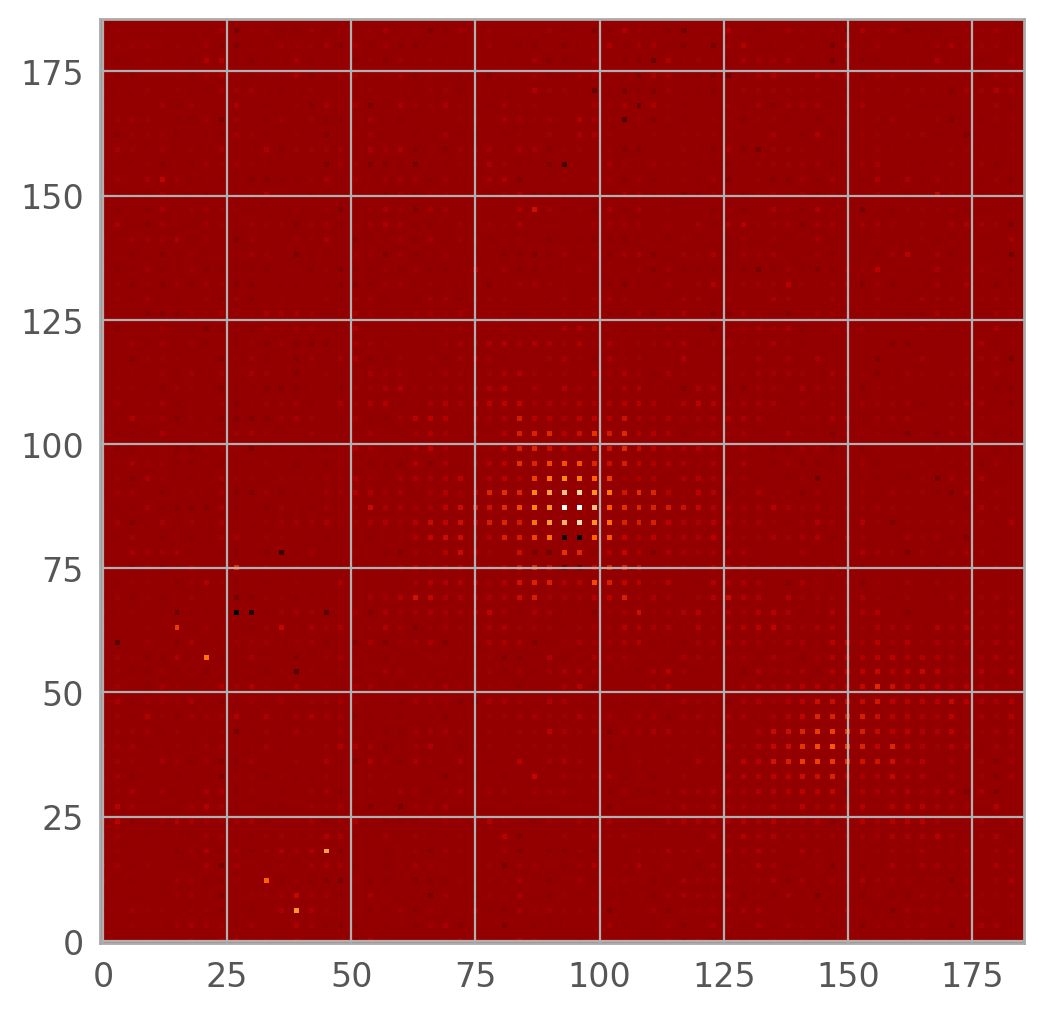

In [117]:

plt.imshow(np.arcsinh(F))

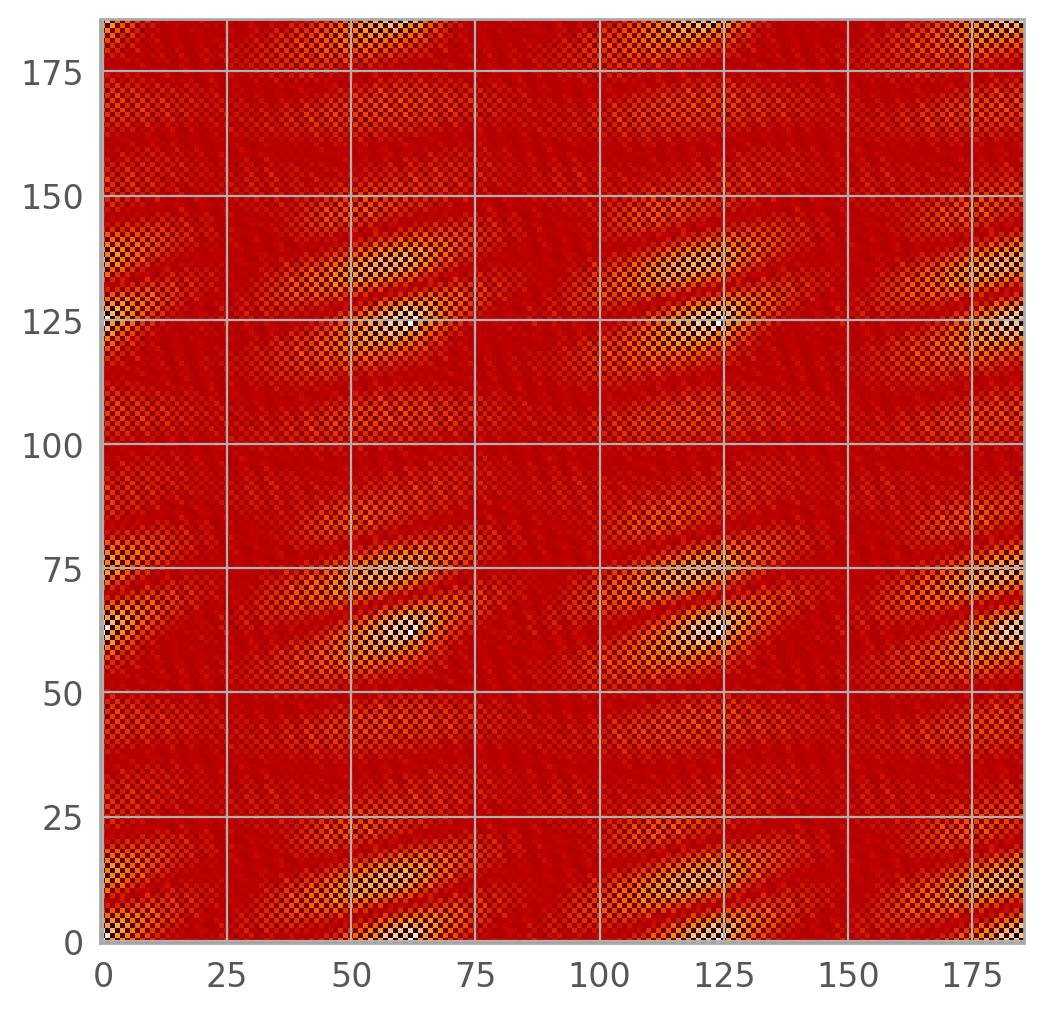

In [114]:
plt.imshow(F_hat[0].real)

In [59]:
np.exp(1j.imag)

2.718281828459045

3j

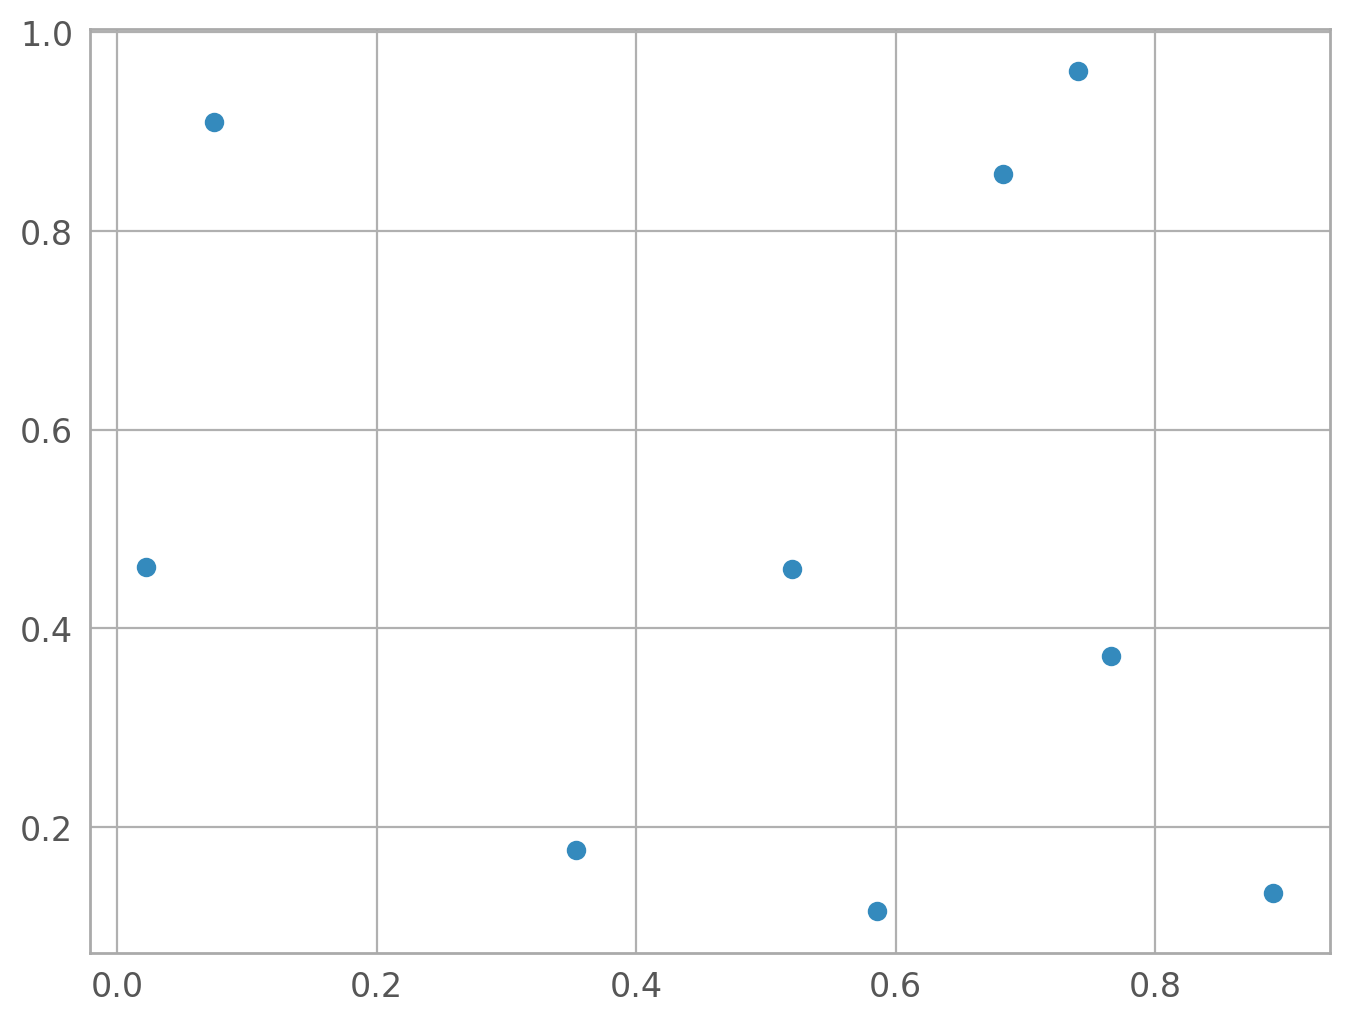

In [254]:
# centeroid calculation from photutils

psf_image = data.copy()

def centroid_com(data):
    data = data.copy()
    total = np.sum(data)
    indices = np.ogrid[tuple(slice(0, i) for i in data.shape)]
    return np.array([np.sum(indices[axis] * data) / total
                    for axis in range(data.ndim)])[::-1]
# xcenter, ycenter = centroid_com(psf_image)

centers = []

for i in range(9): 
    with fits.open(cutout_paths[i]) as hdul: 
        data = hdul['SCI'].data
        center = centroid_com(data)
        centers.append(center)
centers = np.array(centers)

plt.scatter(*(centers-np.floor(centers)).T)


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float32,float64,int64,float64,float64,float64,float64
1,45.995655010356856,11.776593425834205,0.4926771252186493,-0.11133928,-0.27269389080582673,25,0.0,1.3243911266326904,5.007529258728027,-1.7490587388316616
2,51.568542584825636,16.17965026534648,0.6436164715768207,-0.86212075,0.0597012717935261,25,0.0,0.2783406674861908,1.1054770946502686,-0.10887437119897349
3,28.886293669207497,27.76299403985506,0.7011131699730738,0.0027075869,0.005798823132273347,25,0.0,89.05661010742188,461.332763671875,-6.660035747818186
4,32.95008359123685,27.521097547214982,0.5739177495287063,0.45630908,-0.23494817734307305,25,0.0,0.593031644821167,1.9162379503250122,-0.7061235923582194


In [295]:
positions

x,y
float64,float64
45.995655010356856,11.776593425834205
51.568542584825636,16.17965026534648
28.886293669207497,27.76299403985506
32.95008359123685,27.521097547214982


NameError: name 'positions' is not defined

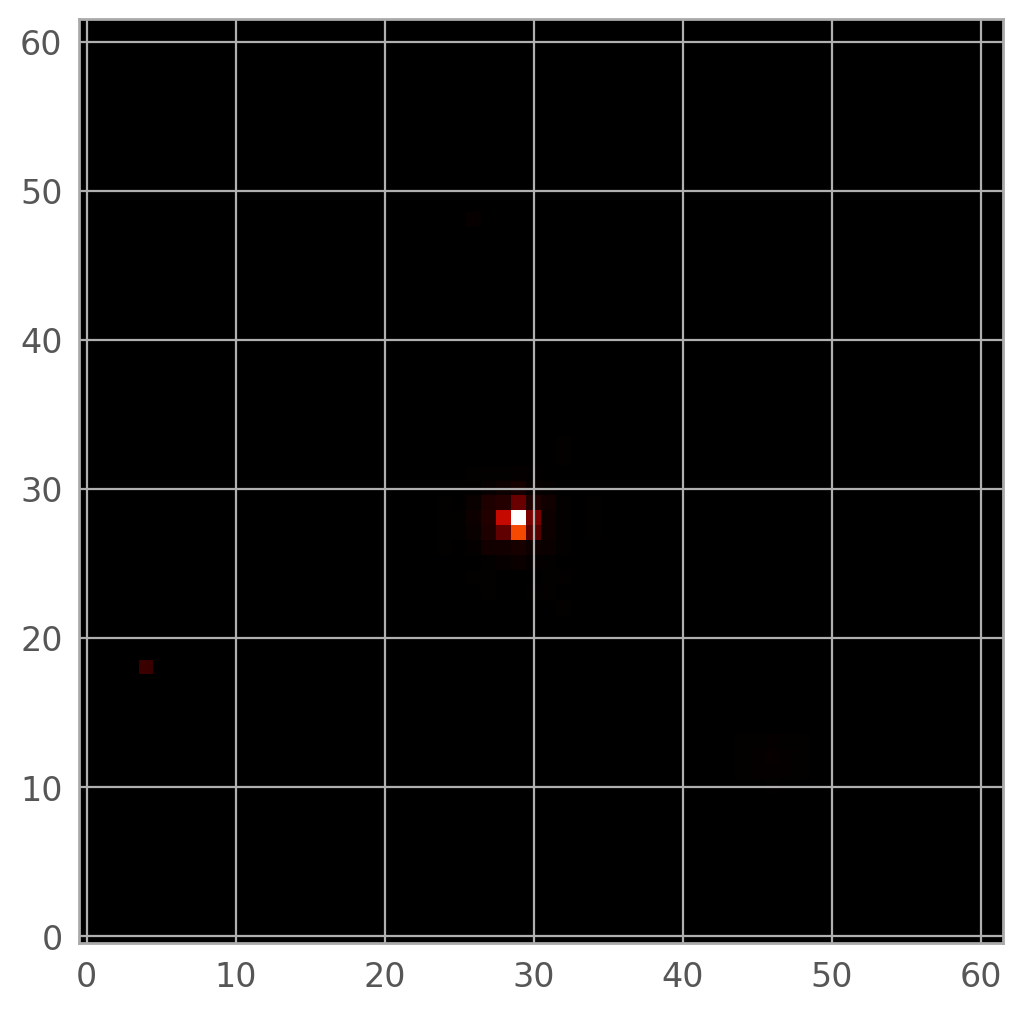

In [9]:
plt.imshow((data))
plt.scatter(positions['x'], positions['y'])

In [261]:
print(EPSFBuilder.__doc__)


    Class to build an effective PSF (ePSF).

    See `Anderson and King (2000; PASP 112, 1360)
    <https://ui.adsabs.harvard.edu/abs/2000PASP..112.1360A/abstract>`_
    and `Anderson (2016; WFC3 ISR 2016-12)
    <https://ui.adsabs.harvard.edu/abs/2016wfc..rept...12A/abstract>`_
    for details.

    Parameters
    ----------
    oversampling : int or array_like (int)
        The integer oversampling factor(s) of the ePSF relative to the
        input ``stars`` along each axis. If ``oversampling`` is a scalar
        then it will be used for both axes. If ``oversampling`` has two
        elements, they must be in ``(y, x)`` order.

    shape : float, tuple of two floats, or `None`, optional
        The shape of the output ePSF. If the ``shape`` is not `None`, it
        will be derived from the sizes of the input ``stars`` and the
        ePSF oversampling factor. If the size is even along any axis,
        it will be made odd by adding one. The output ePSF will always
        have od

In [273]:
EPSFBuilder.__call__.__doc__

plot the position of central pixel

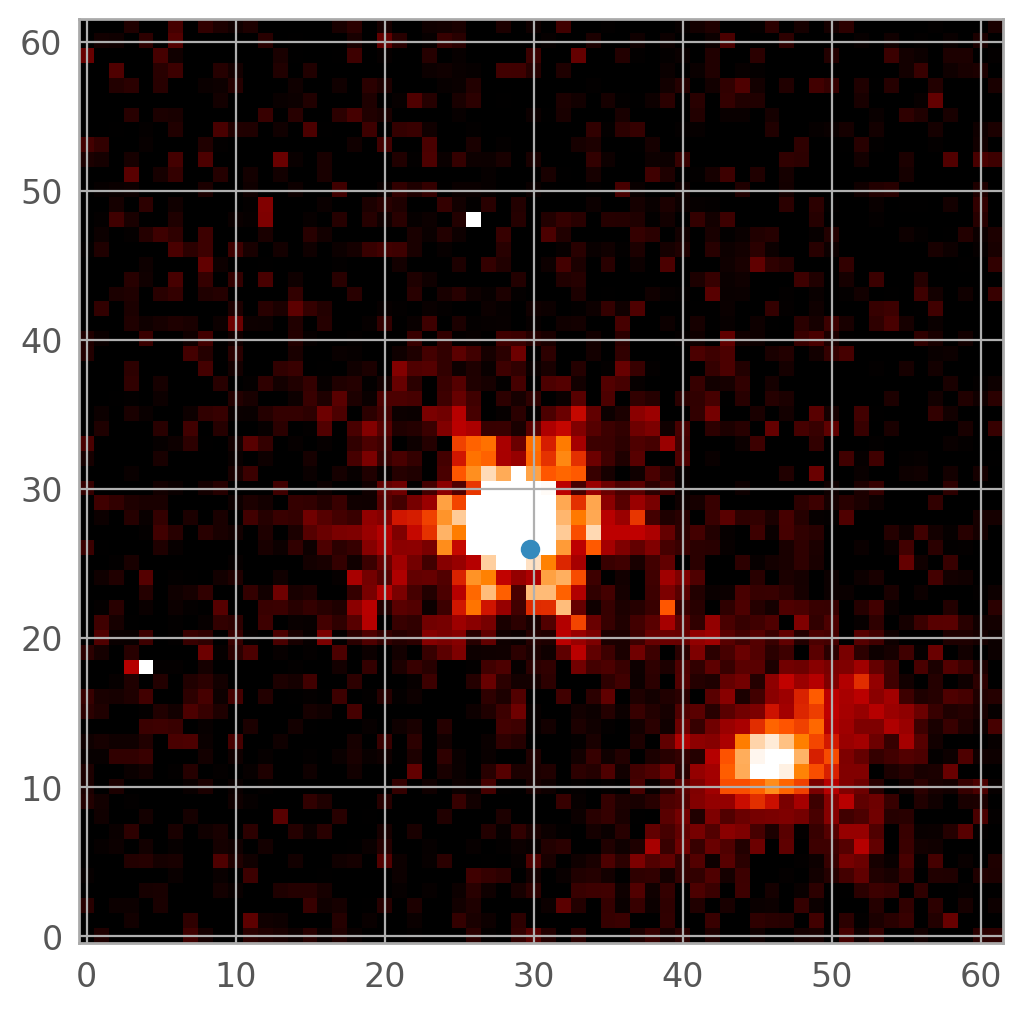

In [250]:
plt.imshow(stretch(data))
plt.scatter(xcenter, ycenter)

In [166]:
center_coords = []
for cutout_path in cutout_paths: 
    center_coord = get_pixel_center_coordinate(cutout_path)[2]
    center_coords.append(center_coord)

Set OBSGEO-B to   -21.934391 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540070416.745 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.938060 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540122949.033 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.941320 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540169631.670 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.944987 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540222135.322 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.948247 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540268792.514 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.951913 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540321267.547 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.955171 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540367899.307 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.958836 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540420345.737 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.931130 from OBSGEO-[XYZ].
Set OBSGEO-H to 

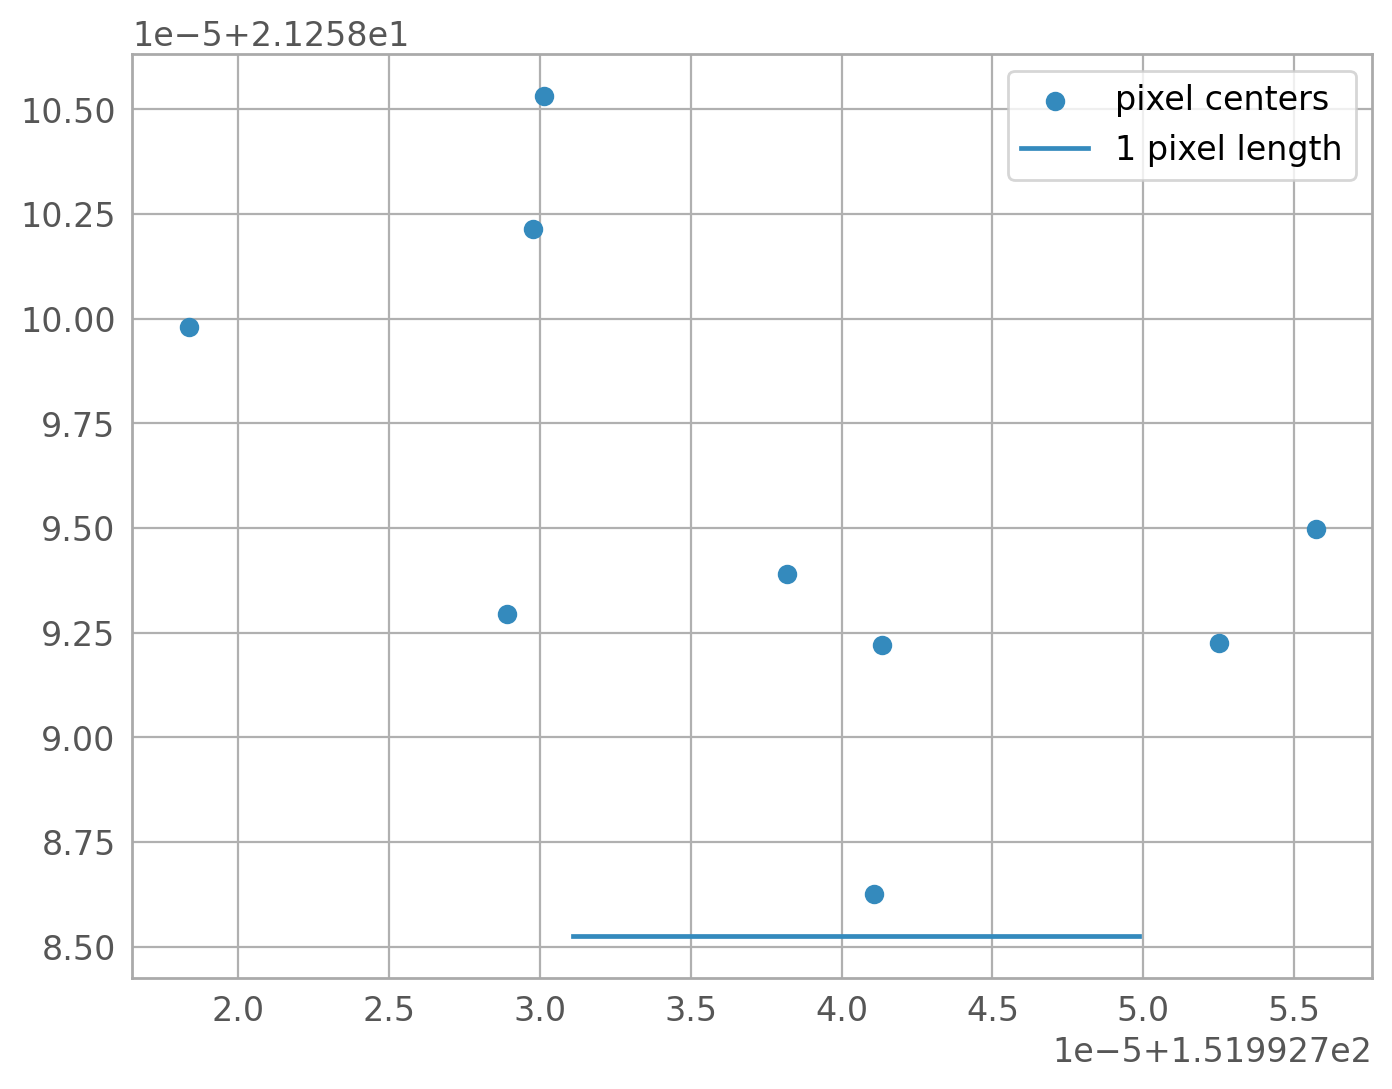

In [167]:
ra = SkyCoord(center_coords).ra.deg
dec = SkyCoord(center_coords).dec.deg

plt.scatter(ra, dec, label='pixel centers')

ra0  = ra[0]-1e-5
dec0 = dec[0]-1e-6
pixel_scale = 0.063/3600 # deg/pixel
plt.plot([ra0, ra0+pixel_scale/np.cos(np.deg2rad(dec0))], [dec0, dec0], label='1 pixel length')

plt.legend(loc='upper right')

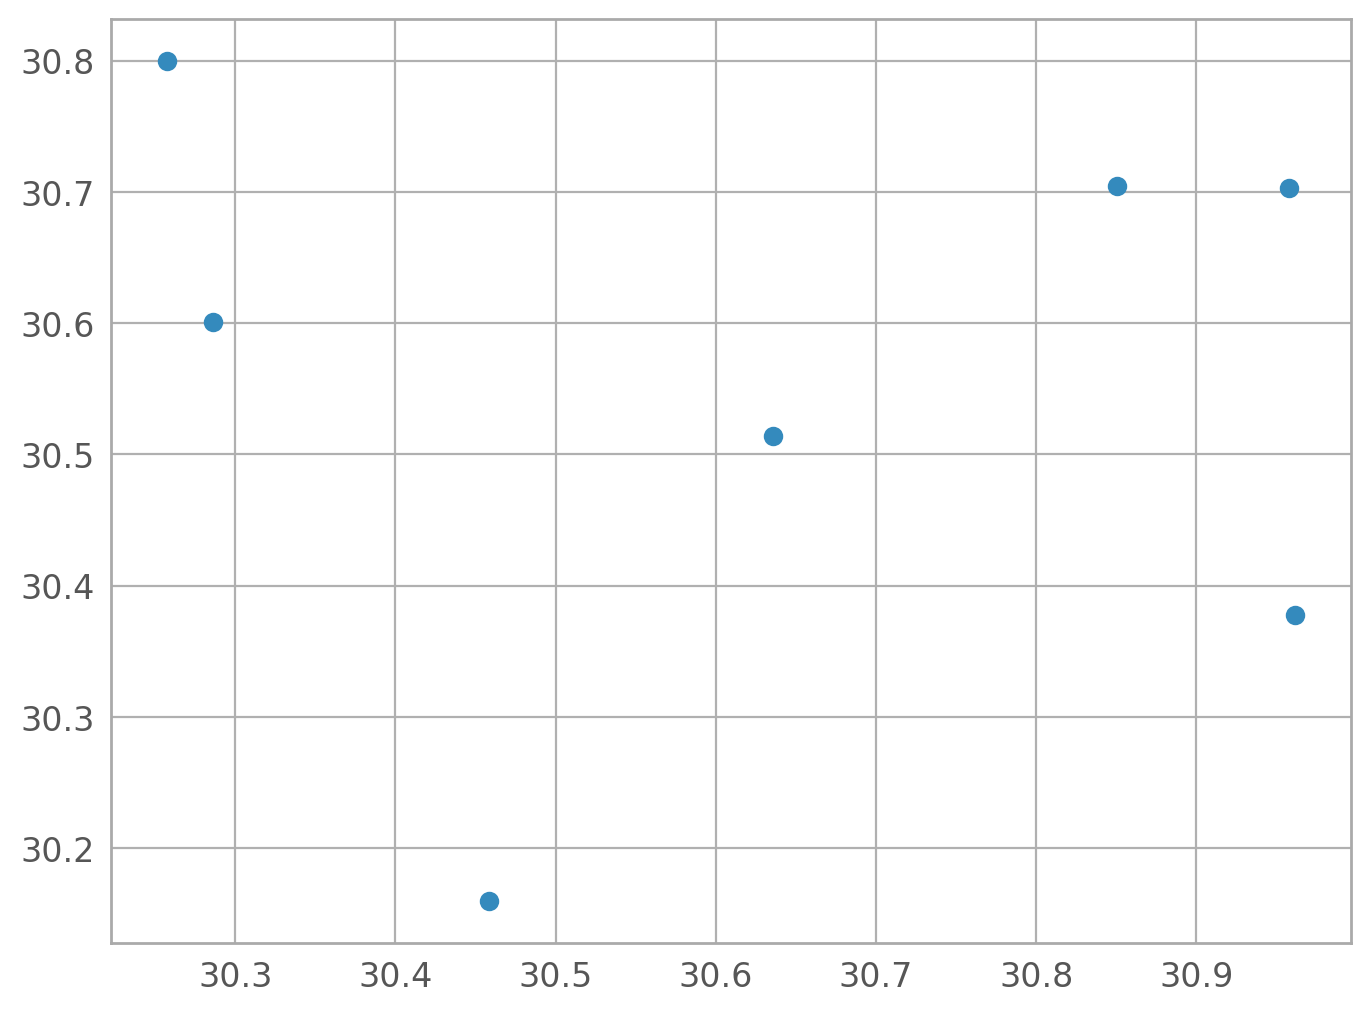

In [225]:
plt.scatter(agn_pixels.T[0, 2:], agn_pixels.T[1, 2:])

In [7]:
import os

def get_file_sizes(file_list):
    sizes = {}
    for file_path in file_list:
        try:
            size = os.path.getsize(file_path)
            sizes[file_path] = size
        except FileNotFoundError:
            sizes[file_path] = "File not found"
        except Exception as e:
            sizes[file_path] = str(e)
    return sizes

# Example usage
file_list = img_paths
file_sizes = get_file_sizes(file_list)
for file_path, size in file_sizes.items():
    print(f"{file_path}: {size} bytes")


/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00002_nrcalong_cal_bsub_aligned.fits: 117550080 bytes
/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00001_nrcalong_cal_bsub_aligned.fits: 117550080 bytes
/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00002_nrcblong_cal_bsub_aligned.fits: 117550080 bytes
/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00003_nrcalong_cal_bsub_aligned.fits: 117550080 bytes
/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00003_nrcblong_cal_bsub_aligned.fits: 117550080 bytes
/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00004_nrcalong_cal_bsub_aligned.fits: 117550080 bytes
/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00004_nrcblong_cal_bsub_aligned.fits: 117550080 bytes
/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00005_nrcalong_cal_bsub_aligned.fits: 117550080 bytes
/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00005_nrcblong_cal_bsub_aligned.fits: 117550080 bytes
/

In [8]:



hdu = fits.open(cutout_path)

plt.imshow(stretch(hdu[1].data))

FileNotFoundError: [Errno 2] No such file or directory: '/quasar/yichenliu/cutout/jw01764001001_02101_00002_nrcalong_cal_bsub_aligned_cutout.fits'

In [9]:
img_paths

['/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00002_nrcalong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00001_nrcalong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00002_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00003_nrcalong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00003_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00004_nrcalong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00004_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00005_nrcalong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00005_nrcblong_cal_bsub_aligned.fits',
 '/quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00006_nrcalong_cal_bsub_aligned.fits',
 '/quasar/data/GO176

Set DATE-AVG to '2023-05-10T02:05:57.403' from MJD-AVG.
Set DATE-END to '2023-05-10T02:09:32.138' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.934391 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540070416.745 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T01:57:32.764' from MJD-AVG.
Set DATE-END to '2023-05-10T02:01:07.499' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.931130 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540023708.650 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:05:57.275' from MJD-AVG.
Set DATE-END to '2023-05-10T02:09:32.010' from MJD-END'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:14:32.731' from MJD-AVG.
Set DATE-END to '2023-05-10T02:18:07.466' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.938060 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540122949.033 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:14:32.667' from MJD-AVG.
Set DATE-END to '2023-05-10T02:18:07.402' from MJD-END'. [astropy.wcs

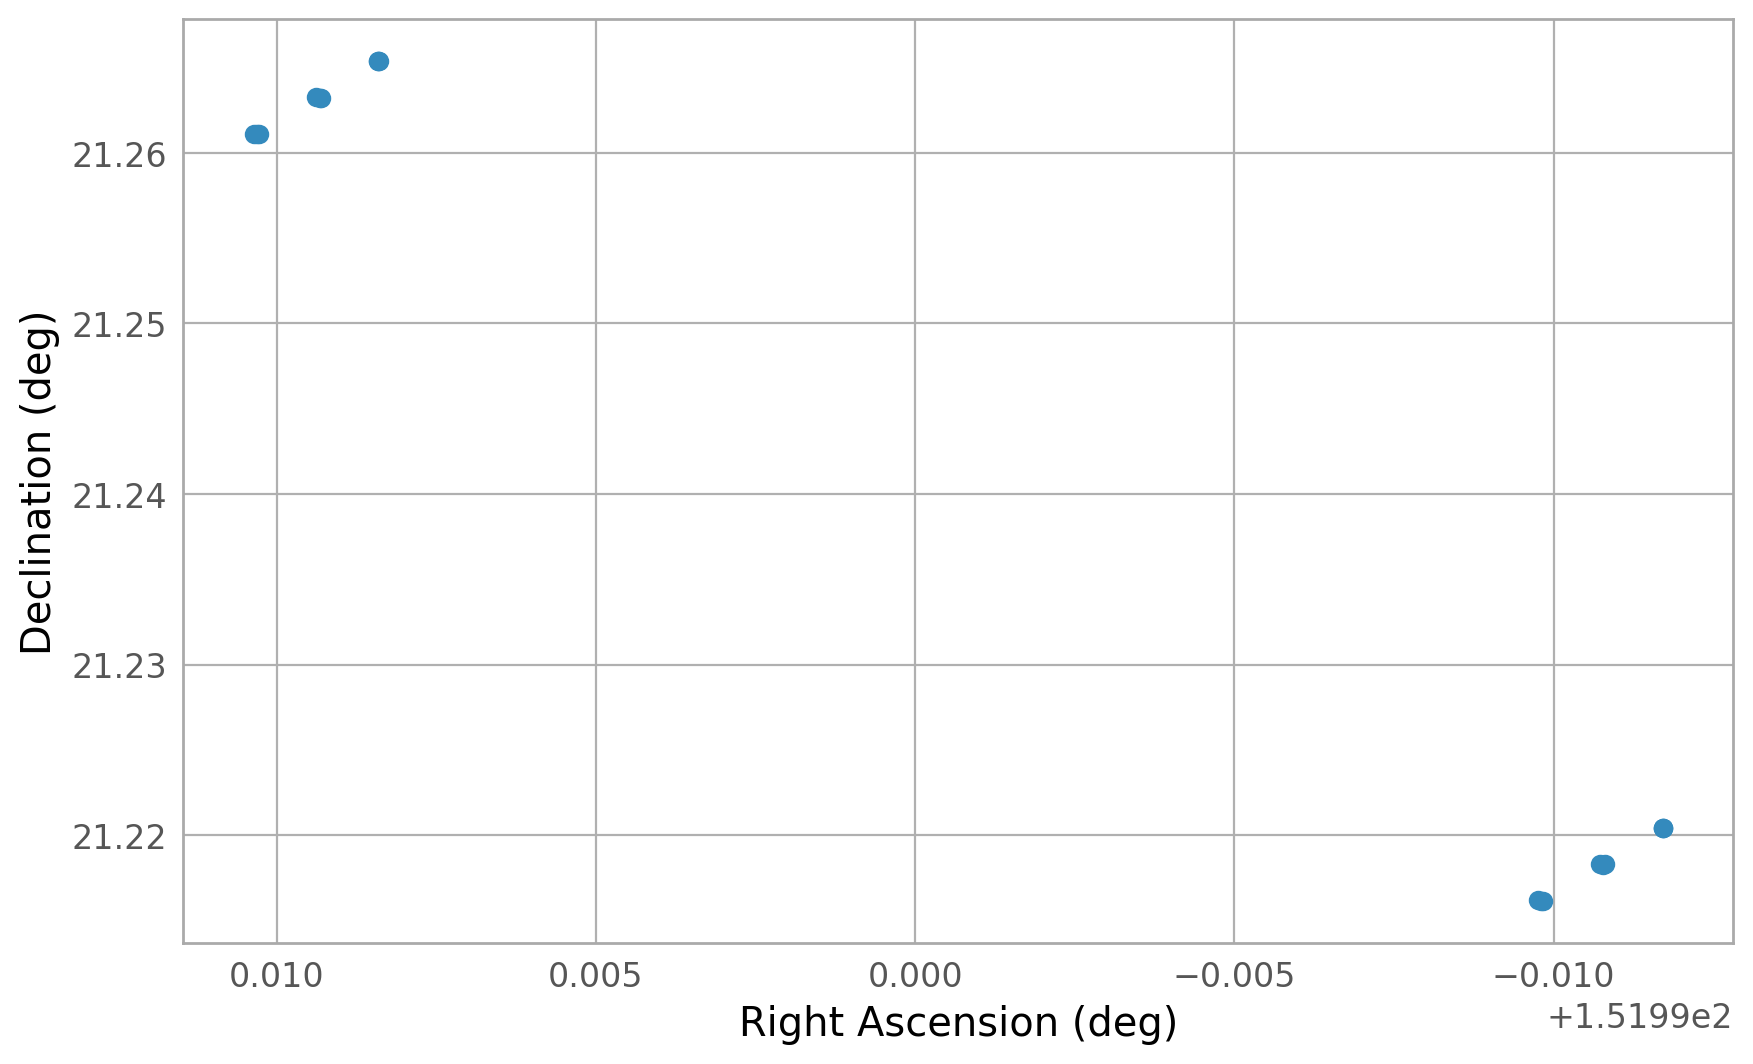

In [10]:
def get_pixel_center_coordinate(fits_path):
    # Open the FITS file
    with fits.open(fits_path) as hdul:
        # Get the WCS from the 'SCI' extension
        wcs = WCS(hdul['SCI'].header)
        
        # Get the dimensions of the image
        ny, nx = hdul['SCI'].data.shape
        
        # Calculate the center pixel coordinates
        center_x = (nx - 1) / 2
        center_y = (ny - 1) / 2
        
        # Convert pixel coordinates to sky coordinates
        sky_coord = wcs.pixel_to_world(center_x, center_y)
        
        return center_x, center_y, sky_coord

skycoords = []
for fits_path in img_paths: 
    center_x, center_y, sky_coord = get_pixel_center_coordinate(fits_path)
    skycoords.append(sky_coord)
# print(f"Sky coordinates at center: {sky_coord}")


ra = [coord.ra.deg for coord in skycoords]
dec = [coord.dec.deg for coord in skycoords]

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(ra, dec)
plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')
plt.gca().invert_xaxis()  # RA increases to the left
plt.grid(True)

plt.plot()
plt.show()

In [81]:
len(img_paths)

18

Set DATE-AVG to '2023-05-10T02:05:57.403' from MJD-AVG.
Set DATE-END to '2023-05-10T02:09:32.138' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.934391 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540070416.745 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T01:57:32.764' from MJD-AVG.
Set DATE-END to '2023-05-10T02:01:07.499' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.931130 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540023708.650 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:05:57.275' from MJD-AVG.
Set DATE-END to '2023-05-10T02:09:32.010' from MJD-END'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:14:32.731' from MJD-AVG.
Set DATE-END to '2023-05-10T02:18:07.466' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -21.938060 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540122949.033 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-05-10T02:14:32.667' from MJD-AVG.
Set DATE-END to '2023-05-10T02:18:07.402' from MJD-END'. [astropy.wcs

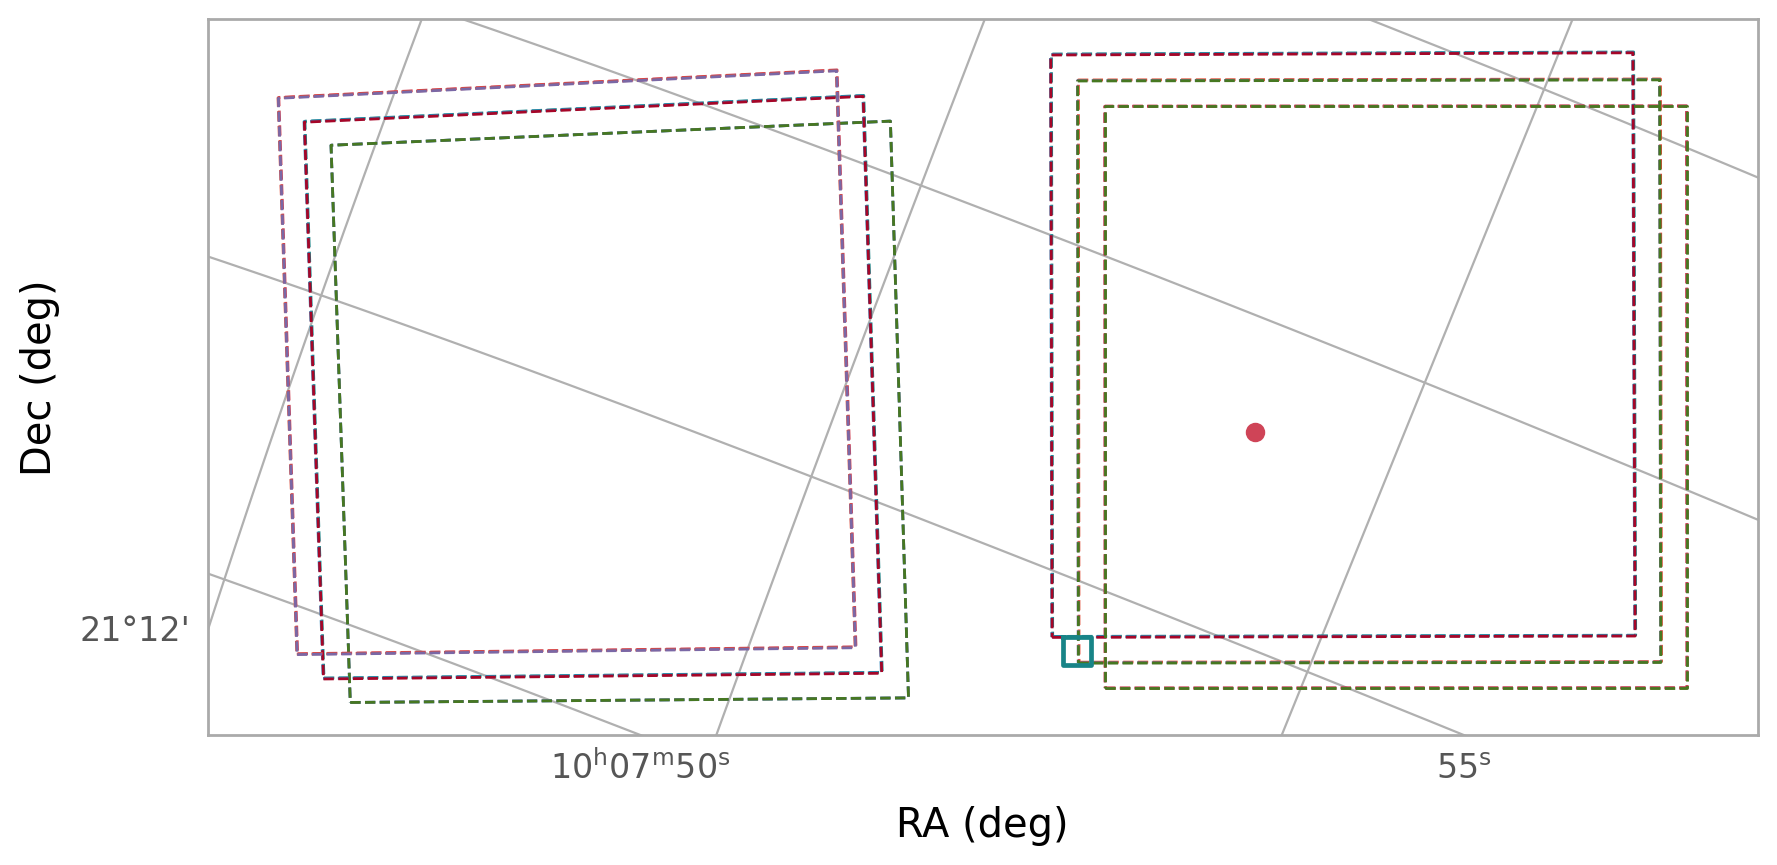

In [106]:
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111, projection=wcs)
ax.set_aspect('equal')

# Load the FITS file
for filename in img_paths: 
    hdulist = fits.open(filename)
    wcs = WCS(hdulist[1].header)

    # Get the shape of the data array
    data_shape = hdulist[1].data.shape

    # Define the pixel coordinates of the corners
    corners = np.array([[0, 0],                    # Bottom-left
                        [0, data_shape[1]-1],      # Bottom-right
                        [data_shape[0]-1, 0],      # Top-left
                        [data_shape[0]-1, data_shape[1]-1]])  # Top-right

    # Convert pixel coordinates to world coordinates
    world_coords = wcs.pixel_to_world(corners[:, 1], corners[:, 0])

    ra = world_coords.ra.deg
    dec = world_coords.dec.deg

    plt.plot(ra[[0, 1, 3, 2, 0]], dec[[0, 1, 3, 2, 0]], linestyle='--', linewidth=1, 
             label=filename[30:40], transform=ax.get_transform('world'))

plt.plot(coord.ra.deg, coord.dec.deg, transform=ax.get_transform('world'), marker='o')

plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

x=-150
y=80
r=100
plt.plot([x, x+r, x+r, x, x], [y+r, y+r, y, y, y+r])
# plt.xlim(x, x+r)
# plt.ylim(y, y+r)
# plt.legend()
plt.grid(True)
plt.show()

In [61]:
ra, dec

array([151.97307029, 151.98781323, 152.00924205, 152.02337491])

In [62]:
coord.ra.deg

151.99275

In [13]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : '' '' 
CRVAL : 0.0 0.0 
CRPIX : 0.0 0.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 1.0 1.0 
NAXIS : 0  0

In [17]:
hdulist.info()

Filename: /quasar/data/GO1764/NIRCam/redux_v01/jw01764001001_02101_00002_nrcalong_cal_bsub_aligned.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     361   ()      
  1  SCI           1 ImageHDU       118   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [33801B]   


In [19]:
hdulist[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2048                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SCI     '           / extension name                                 
MJD-BEG =    60074.08498457407 / [d] exposure start time in MJD                 
MJD-AVG =     60074.0874699375 / [d] exposure mid-point in MJD                  
MJD-END =    60074.08995530093 / [d] exposure end time in MJD                   
TDB-BEG =    60074.08365043581 / [d] TDB time of exposure start in MJD          
TDB-MID =    60074.086135567